# Load VAE

In [3]:
%load_ext autoreload
%autoreload 3

In [2]:
from fsddpm.datasets.colored_mnist import get_dataset 

import matplotlib.pyplot as plt
from torch import nn
import torch
from torchvision.utils import make_grid
from tqdm.auto import tqdm

import numpy as np
import torch.nn.functional as F
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        conv_features_shape = (96, 14, 14)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 96, 3, padding='same'),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, padding='same'),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(np.prod(conv_features_shape), 32),
            nn.ReLU(),
            nn.Linear(32, 2*latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 96*14*14),
            nn.Unflatten(dim=1, unflattened_size=(96, 14, 14)),
            nn.ConvTranspose2d(96, 96, kernel_size=2, stride=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 3, padding='same', kernel_size=3),
            # nn.Sigmoid()
            # nn.Tanh()
        )
        
    def reparam(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
        
    def forward(self, x):
        mu, log_var = self.encoder(x).chunk(2, dim=1)
        z = self.reparam(mu, log_var)
        return self.decoder(z), mu, log_var

In [8]:
VAE_CKPT_PATH = './vae_param932k_latdim6_kl5e-4_epoch50_bs128.ckpt'
LATENT_DIM = 6

vae = VAE(LATENT_DIM)
vae.load_state_dict(torch.load(VAE_CKPT_PATH))

<All keys matched successfully>

### Sample & Reconstruction visualization

In [11]:
def tensor2img(tensor):
    return ((tensor.cpu().clip(-1, 1) + 1)/2).permute(1,2,0)

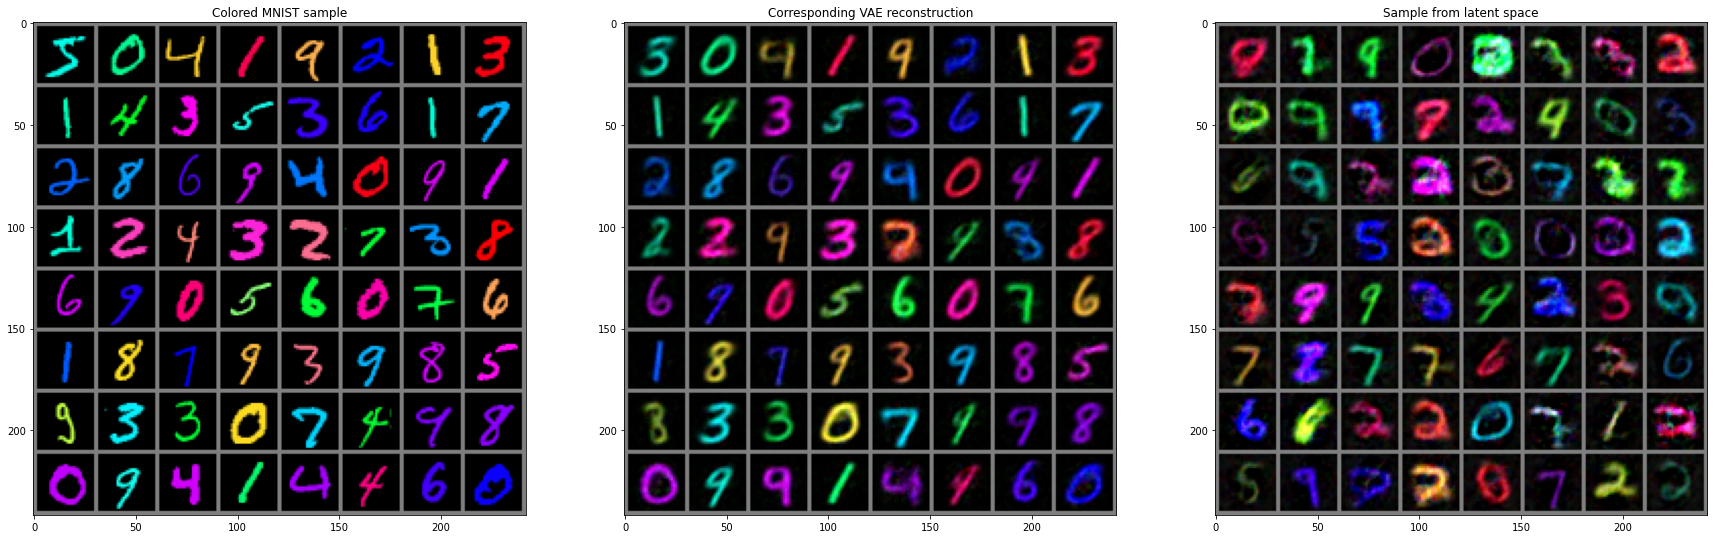

In [23]:
_, test_ds = get_dataset('./')
test_loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=64, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    ### sample 
    z = torch.randn(64, LATENT_DIM)
    sample = vae.decoder(z)
    
    latent_grid = make_grid(sample)
    
    ### reconstruction
    x, _ = next(iter(test_loader))
    x = x[:64]
    recon_x, _, _ = vae(x)
    
    orig_grid = make_grid(x)    
    recon_grid = make_grid(recon_x)
    
    
fig, ax = plt.subplots(1, 3, figsize=(30,10))

ax[0].imshow(tensor2img(orig_grid))
ax[0].set_title('Colored MNIST sample')
ax[1].imshow(tensor2img(recon_grid))
ax[1].set_title('Corresponding VAE reconstruction')
ax[2].imshow(tensor2img(latent_grid))
ax[2].set_title('Sample from latent space')
fig.show()

# ES-DDPM

Load trained DDPM

In [99]:
from diffusers import UNet2DModel, DDPMScheduler
device = 'cuda'

ddpm_model = UNet2DModel.from_pretrained('ddpm_pipeline_epoch69/unet').to(device)
ddpm_noise_scheduler = DDPMScheduler.from_pretrained('ddpm_pipeline_epoch69/scheduler')

In [139]:
with torch.no_grad():
    z = torch.randn(100, LATENT_DIM)
    z_decoded = vae.decoder(z)

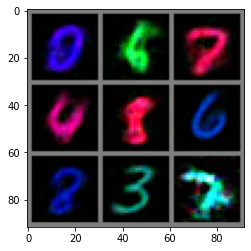

In [138]:
plt.imshow(tensor2img(make_grid(z_decoded, 3)))

In [106]:
len(ddpm_noise_scheduler)

1000

In [180]:
es_ts = 999 # early step time-step
x_es_ts = ddpm_noise_scheduler.add_noise(z_decoded, 
                                        torch.randn(z_decoded.shape), 
                                        torch.tensor([es_ts]*len(z_decoded))
                                       )

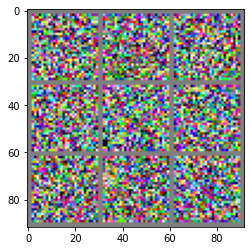

In [181]:
plt.imshow(tensor2img(make_grid(x_es_ts[:9], 3)))

In [182]:
def sample_ddpm(model, noise_scheduler, x_es_ts, es_ts):
    sample = x_es_ts.to(device)
    batch_size = x_es_ts.shape[0]
    timesteps = list(range(es_ts))[::-1]
    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t,  batch_size)).long().to(device)
        with torch.no_grad():
            residual = model(sample, t)['sample']
        sample = noise_scheduler.step(residual, t[0], sample)['prev_sample']
    return sample

In [183]:
x_0 = sample_ddpm(ddpm_model, ddpm_noise_scheduler, x_es_ts, es_ts)

  0%|          | 0/999 [00:00<?, ?it/s]

### Save for FID calculating

In [184]:
from PIL import Image
for i in tqdm(range(x_0.shape[0])):
    img = (x_0[i].permute(1,2,0) * 0.5 + 0.5).cpu().numpy()*255
    img = img.astype(np.uint8)
    dr = f'./esddpm_samples/t_{es_ts}'
    os.makedirs(dr, exist_ok=True)
    Image.fromarray(img).save(f'{dr}/{i:04}.png')

  0%|          | 0/1000 [00:00<?, ?it/s]

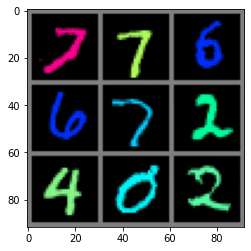

In [185]:
plt.imshow(tensor2img(make_grid(x_0[:9], 3)))

# After calculating FID

Text(0.5, 1.0, 'ESDDPM + VAE')

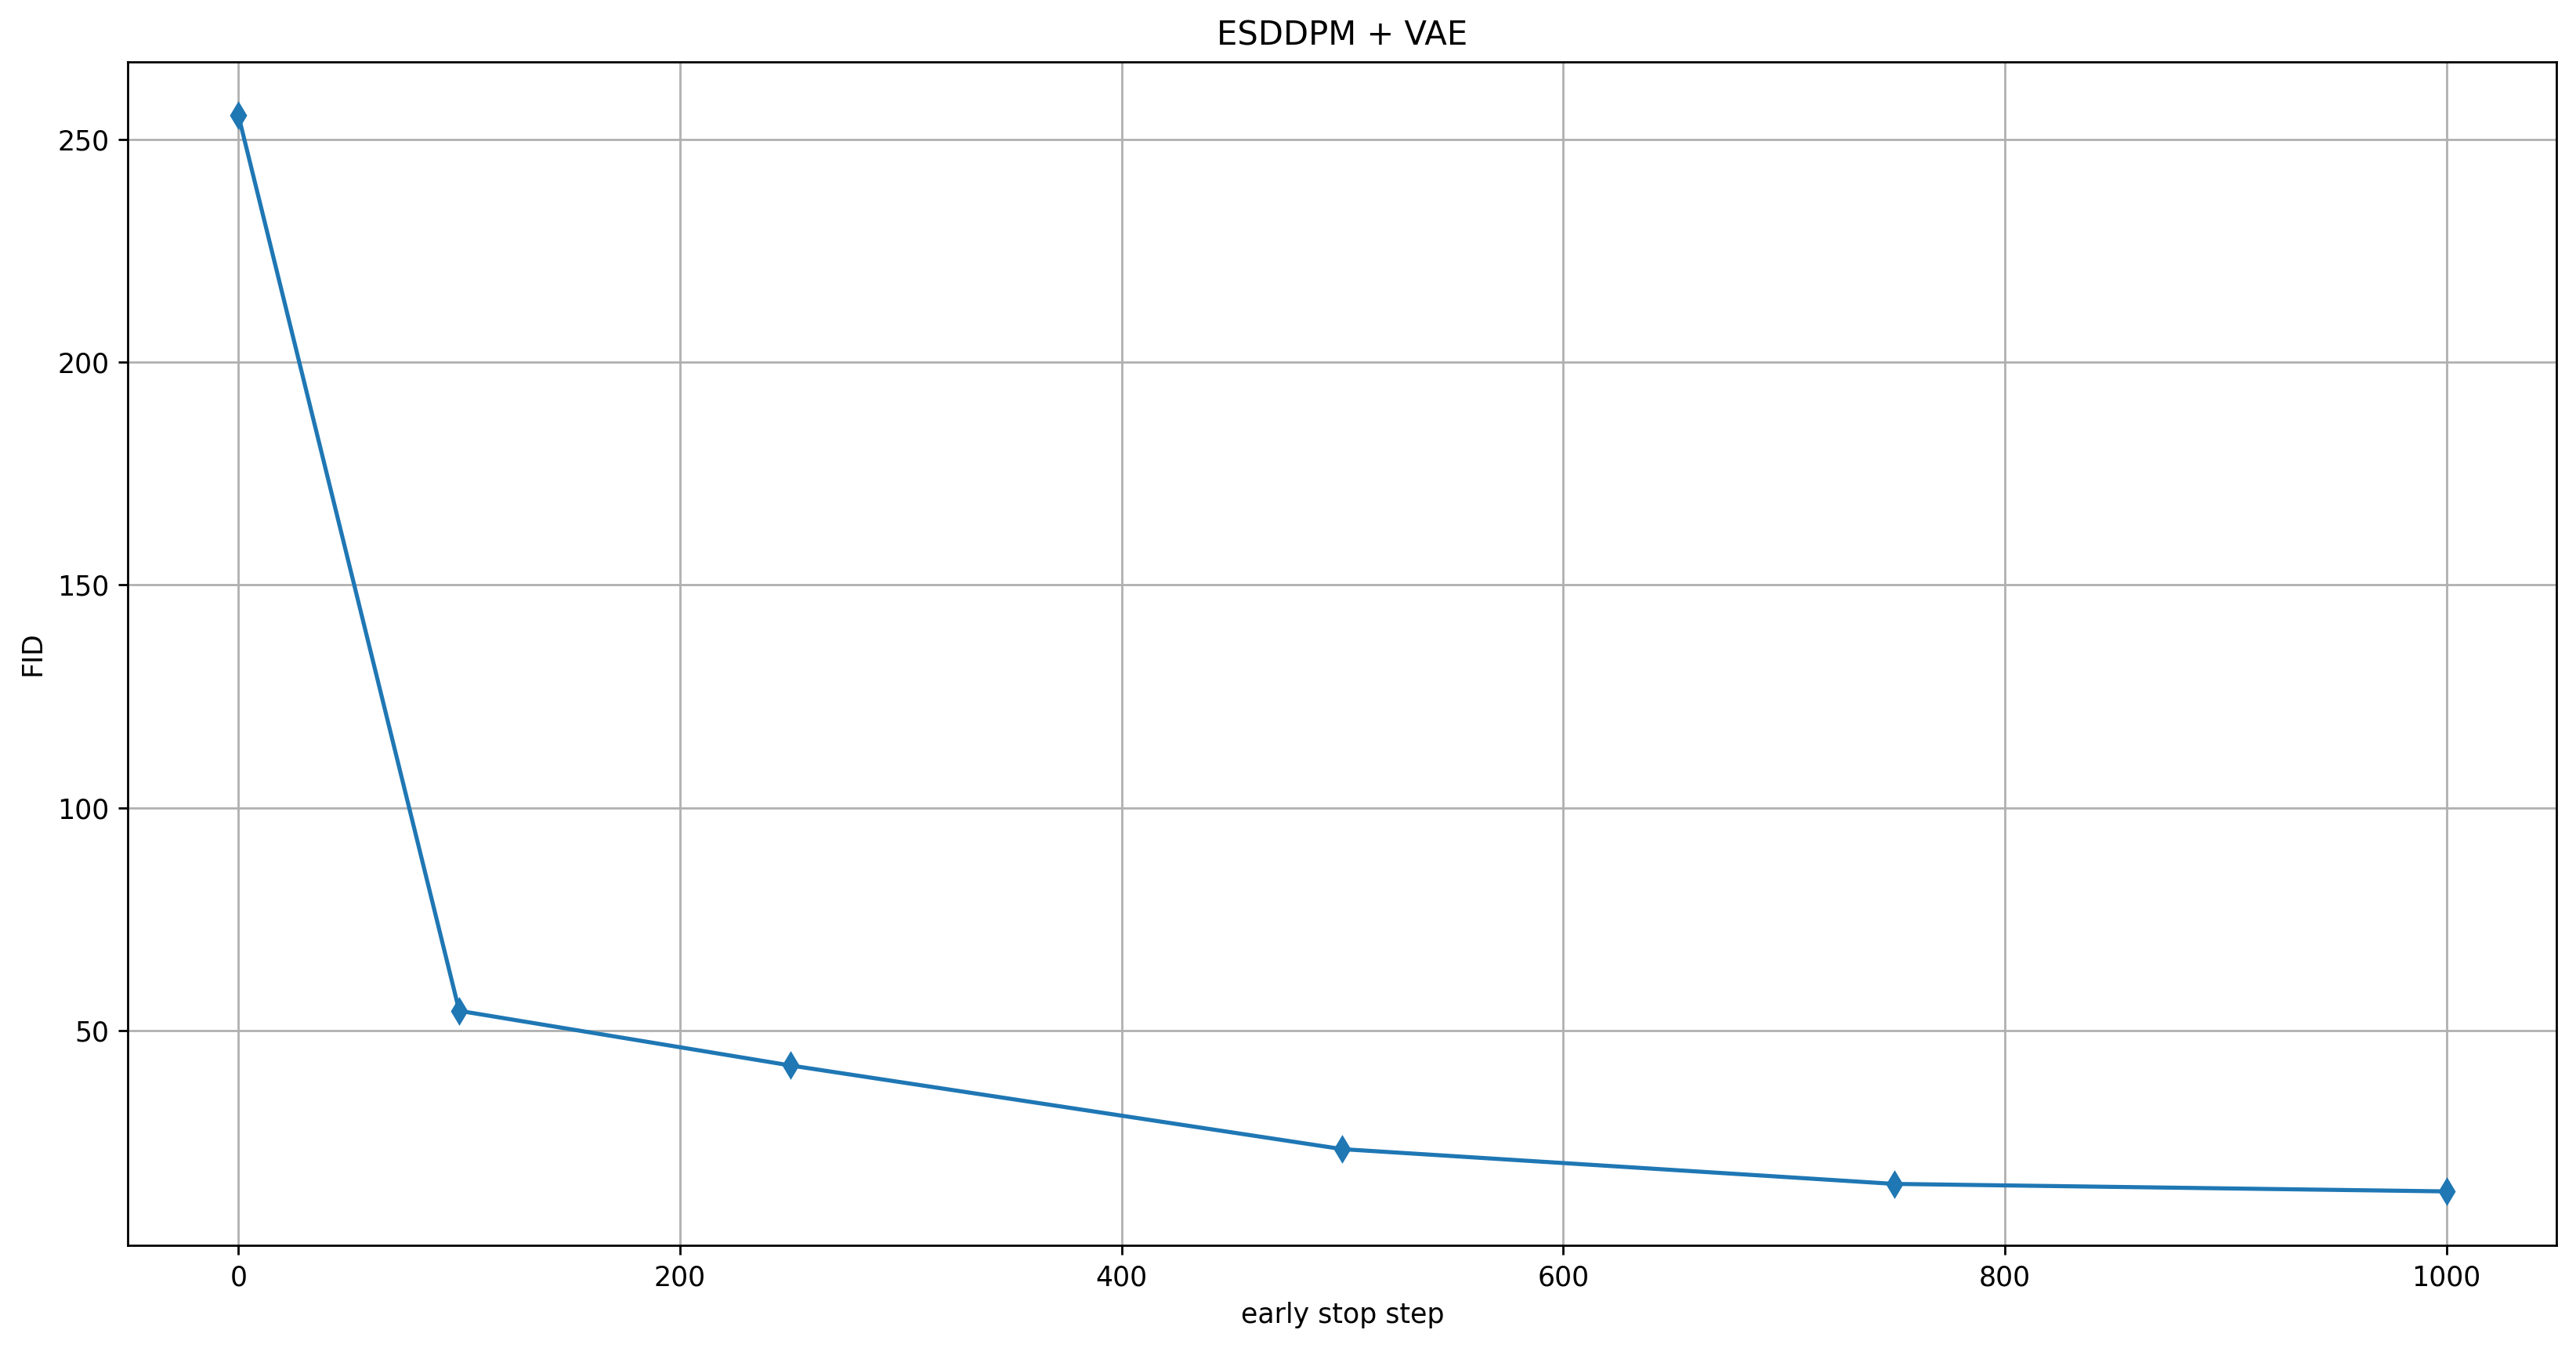

In [199]:
steps = [0, 100, 250, 500, 750, 1000]
fids = [255.31, 54.41, 42.15, 23.37, 15.57, 13.89]

plt.figure(figsize=(16, 8), dpi=250)
plt.plot(steps, fids, marker='d')
plt.grid()
plt.xlabel('early stop step')
plt.ylabel('FID')
plt.title('ESDDPM + VAE')